In [1]:
%cd ..

import torch
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image
from torchvision import transforms
from model import DeepJSCC
from alignment.aligned_model import AlignedDeepJSCC, _LinearAlignment
from utils import get_psnr, image_normalization

os.getcwd()
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

d:\File\Repos\Deep-JSCC-PyTorch


In [18]:
channel = 'AWGN'
model1_fp = r'alignment\models\seed42_v1.pkl'
model2_fp = r'alignment\models\seed43_v1.pkl'
aligner_fp = r'alignment\models\aligner.pkl'
saved = r'out\checkpoints\CIFAR10_8_7.0_0.17_AWGN_11h35m08s_on_Mar_27_2025\epoch_999.pkl'

snr = 7
test_image_dir = r'demo\0000.jpg'
times = 10

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [25]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((64, 64))])
test_image = Image.open(test_image_dir)
test_image.load()
test_image = transform(test_image)

In [12]:
def load_from_checkpoint(path, snr):
    state_dict = torch.load(path, map_location=torch.device('cpu'))
    from collections import OrderedDict
    new_state_dict = OrderedDict()

    for k, v in state_dict.items():
        name = k.replace('module.','') # remove `module.`
        new_state_dict[name] = v

    file_name = os.path.basename(os.path.dirname(saved))
    c = file_name.split('_')[1]
    c = int(c)
    model = DeepJSCC(c=c, channel_type=channel, snr=snr)

    model.load_state_dict(new_state_dict)
    model.change_channel(channel, snr)

    return model

model1 = load_from_checkpoint(model1_fp, snr)
model2 = load_from_checkpoint(model2_fp, snr)

with open(aligner_fp, 'rb') as f:
    align_matrix = pickle.load(f)

aligner = _LinearAlignment(align_matrix)

aligned_model = AlignedDeepJSCC(model1, model2, aligner)
unaligned_model = AlignedDeepJSCC(model1, model2, None)

In [13]:
def evaluation_pipeline(model):
    psnr_all = 0.0
    with torch.no_grad():

        for _ in range(times):
            demo_image = model(test_image)
            demo_image = image_normalization('denormalization')(demo_image)
            gt = image_normalization('denormalization')(test_image)
            psnr_all += get_psnr(demo_image, gt)

        demo_image = image_normalization('normalization')(demo_image)
        demo_image = torch.cat([test_image, demo_image.squeeze()], dim=1)
        demo_image = demo_image.numpy()

    dpi = 100
    height, width = demo_image.shape[1], demo_image.shape[2]
    figsize = (width / dpi, height / dpi)

    fig = plt.figure(figsize=figsize, dpi=dpi)
    plt.imshow(demo_image.transpose(1, 2, 0))
    plt.axis('off')

    print("average psnr is {} for {} times on {}".format( psnr_all.item() / times, times, os.path.basename(test_image_dir)))

In [14]:
def evaluation_pipeline(model, upscale_factor=8):  # Adjust factor as needed
    psnr_all = 0.0
    with torch.no_grad():
        for _ in range(times):
            demo_image = model(test_image)
            demo_image = image_normalization('denormalization')(demo_image)
            gt = image_normalization('denormalization')(test_image)
            psnr_all += get_psnr(demo_image, gt)

        # Prepare image for visualization
        demo_image = image_normalization('normalization')(demo_image)
        demo_image = torch.cat([test_image, demo_image.squeeze()], dim=1)  # (C, H, W)
        demo_image = demo_image.numpy()  # (C, H, W)
        demo_image = demo_image.transpose(1, 2, 0)  # Convert to (H, W, C) for PIL

        # Convert to PIL image and upscale
        pil_image = Image.fromarray((demo_image * 255).astype(np.uint8))
        new_size = (pil_image.width * upscale_factor, pil_image.height * upscale_factor)
        pil_image = pil_image.resize(new_size, Image.NEAREST)  # Use NEAREST or BICUBIC

    # Show the upscaled image
    plt.figure(figsize=(new_size[0] / 100, new_size[1] / 100), dpi=100)
    plt.imshow(pil_image)
    plt.axis('off')
    plt.show()

    print("Average PSNR is {:.2f} over {} runs on {}".format(psnr_all.item() / times, times, os.path.basename(test_image_dir)))

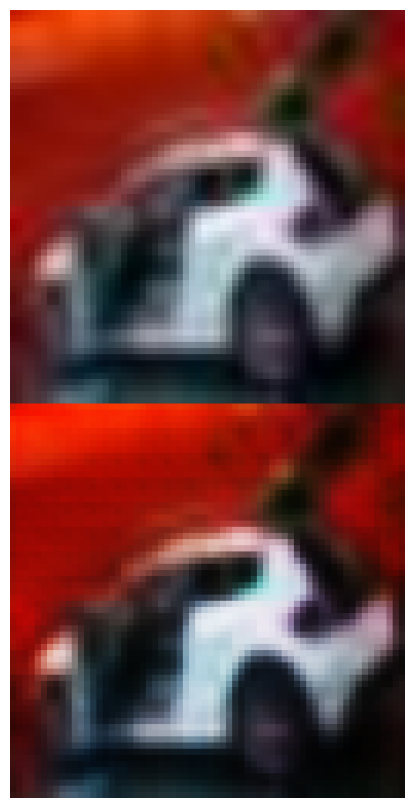

Average PSNR is 24.23 over 10 runs on 0000.jpg


In [26]:
# without semantic mismatch
evaluation_pipeline(model1)

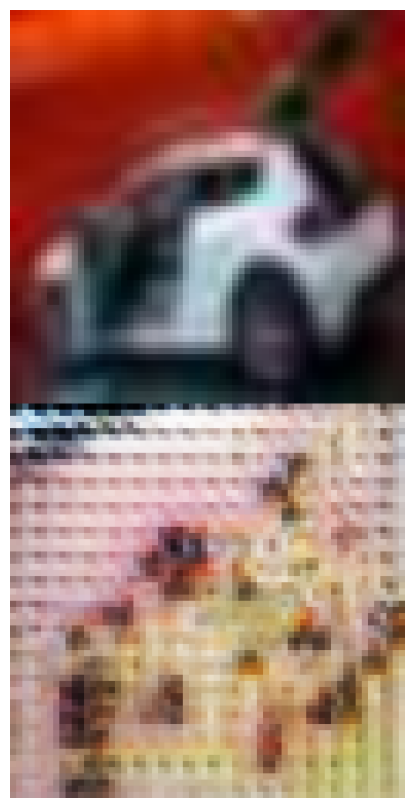

Average PSNR is 6.84 over 10 runs on 0000.jpg


In [21]:
# with semantic mismatch, without aligning
evaluation_pipeline(unaligned_model)

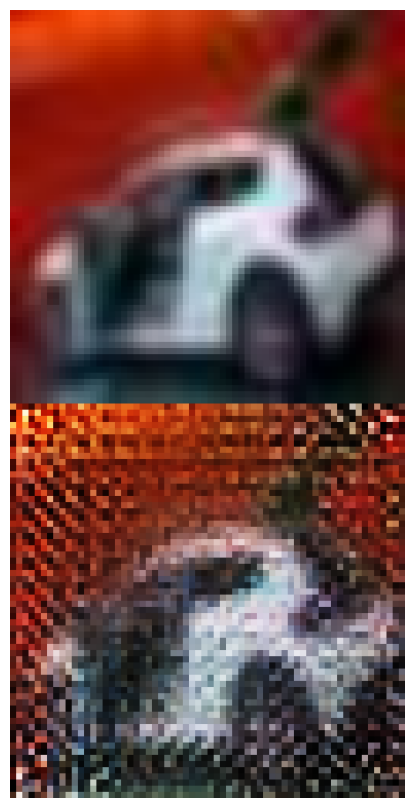

Average PSNR is 17.70 over 10 runs on 0000.jpg


In [22]:
# with semantic mismatch, with aligning
evaluation_pipeline(aligned_model)